#### Funksione ndihmese

In [1]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib.request as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

from_date="2013-04-28"
to_date="2018-10-30"
my_cryptory = Cryptory(from_date=from_date, to_date=to_date)

def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

"""
Funksioni merr ekstrakton te dhenat nga API-te publike perkatese

start_date: te dhenat qe kane date me te vogel se start_date do te fshihen
new_col_name: specifikon emrin e ri te kolones (meqe cdo dataset qe perdor kete funksion ka vetem 2 kolona, 
              ate te dates dhe nje kolone specifike te datasetit)
"""
def drop_initial_rows(api, new_col_name, start_date='2013-04-28'):
    # Read data 
    api_range_format= api
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', new_col_name])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    elif 'my-wallet-n-users' in api:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date'] = df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df    
    
    else:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date'] = df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

### Ngakimi i te dhenave nga API-te perkatese
1. Te dhenat merren ne intervalin nga 2013-04-28 deri ne 2018-10-30
2. Te dhenat jane ditore

##### Ekstraktimi i te dhenave historike

In [2]:
# Marrja e te dhenave historike ne Coinmarketcap
exchange_data = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20181030")[0]

In [3]:
exchange_data.rename(columns={'Date': 'date', 'Open*': 'open', 'High': 'high', 'Low': 'low', \
                                    'Close**': 'close', 'Volume': 'volume', \
                                    'Market Cap': 'market_cap'}, inplace=True)
# convert the date string to the correct date format
exchange_data = exchange_data.assign(date=pd.to_datetime(exchange_data['date']))

# when Volume is equal to '-' convert it to 0
exchange_data.loc[exchange_data['volume']=="-",'volume']=0
# convert to int
exchange_data['volume'] = exchange_data['volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
exchange_data.columns = exchange_data.columns.str.replace("*", "")
# look at the first few rows
# exchange_data.head()
exchange_data.to_csv('exchange_data.csv')

##### Ekstraktimi i te dhenave te blockchain-it

In [4]:
# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size?timespan=all&format=csv" 
avg_block_size_data = drop_initial_rows(block_size_api, 'avg_block_size')

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions?timespan=all&format=csv" 
txs_data = drop_initial_rows(txs_api, 'transactions')

# Get revenue of Bitcoin Miners
bchain_mirev_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/MIREV.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_mirev_data = drop_initial_rows(bchain_mirev_api, "mining_revenue")

# Get number of wallet-users 
bch_accounts_api = "https://api.blockchain.info/charts/my-wallet-n-users?timespan=all&format=csv"
bch_accounts_data = drop_initial_rows(bch_accounts_api, 'accounts')

# Merge blockchain data together
blockchain_data = avg_block_size_data.merge(txs_data, on='date', how='inner'). \
            merge(bchain_mirev_data, on='date', how='inner'). \
            merge(bch_accounts_data, on='date', how='inner')

In [5]:
# Gist of it
blockchain_data.tail()
blockchain_data.to_csv('blockchain_data.csv')
blockchain_data.isnull().values.any()

False

#### Ekstraktimi i te dhenave makroekonomike

In [6]:
# S&P 500 price index from Yahoo Finance
s_and_p_stock = my_cryptory.get_stock_prices(market="%5EGSPC")
s_and_p_stock = s_and_p_stock.loc[:,['date', 'close']]
s_and_p_stock = s_and_p_stock.rename(columns={'close': 'sp_close'})

# Dow and Jones
dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]
dow_jones_stock = dow_jones_stock.rename(columns={'close': 'dj_close'})

macro_econ_data = s_and_p_stock.merge(dow_jones_stock,on='date', how='inner')

#### Ekstraktimi i te dhenave te Sentimentit

In [7]:
# Get Google Trends data
btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
sentiment_data = btc_google_trends

#### Riemertim i kolonave

In [8]:
exchange_data.columns =[exchange_data.columns[0]]+['btc_'+i for i in exchange_data.columns[1:]]
blockchain_data.columns =[blockchain_data.columns[0]]+['bch_'+i for i in blockchain_data.columns[1:]]
sentiment_data.columns = [sentiment_data.columns[0]] + ['google_trends_'+i for i in sentiment_data.columns[1:]]

#### Vizualizimi i te dhenave te cmimit

In [9]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

btc_trace_high = go.Scatter(
                x=exchange_data.date,
                y=exchange_data['btc_high'],
                name = "Bitcoin High",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

btc_trace_low = go.Scatter(
                x=exchange_data.date,
                y=exchange_data['btc_low'],
                name = "Bitcoin Low",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)


data = [btc_trace_high,btc_trace_low]

layout = dict(
    title = "Levizjet ne Cmimin e Bitcoin",
    xaxis = dict(
        range = ['2013-04-28','2018-10-01'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Levizjet ne Cmimin e Bitcoin")

#### Ruajme dataset-et e vecante 

In [9]:
exchange_data.to_csv('exchange_data.csv')
blockchain_data.to_csv('blockchain_data.csv')
macro_econ_data.to_csv('macro_econ_data.csv')
sentiment_data.to_csv('sentiment_data.csv')

In [20]:
model_data = exchange_data.merge(blockchain_data, on='date', how='inner'). \
            merge(macro_econ_data,on='date' ,how='inner'). \
            merge(sentiment_data, on='date', how='inner')

#### Heqim kolonat qe nuk na interesojne: cmimi i hyrjes, cmimi i hapjes

In [21]:
model_data=model_data.drop(columns=['btc_open', 'btc_low'])

#### Fshij rekordet qe u perkasin te dhenave para 2014

In [22]:
model_data=model_data[model_data['date']>='2014-01-01']

#### Vizualizojme korrelacionin e Pearson-it mes atributeve

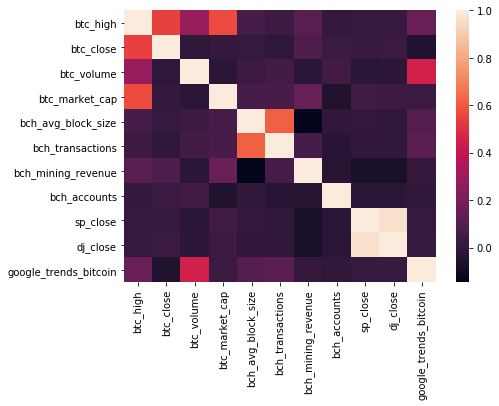

,btc_high,btc_close,btc_volume,btc_market_cap,bch_avg_block_size,bch_transactions,bch_mining_revenue,bch_accounts,sp_close,dj_close,google_trends_bitcoin
btc_high,1,0.54,0.29,0.57,0.066,0.038,0.12,0.013,0.016,0.02,0.16
btc_close,0.54,1,-0.0035,0.012,0.018,-0.0057,0.089,0.031,0.027,0.031,-0.044
btc_volume,0.29,-0.0035,1,-0.013,0.042,0.056,-0.016,0.051,-0.019,-0.01,0.45
btc_market_cap,0.57,0.012,-0.013,1,0.071,0.07,0.16,-0.052,0.047,0.041,0.03
bch_avg_block_size,0.066,0.018,0.042,0.071,1,0.62,-0.15,0.002,0.008,0.00081,0.1
bch_transactions,0.038,-0.0057,0.056,0.07,0.62,1,0.065,-0.023,0.0032,0.0026,0.13
bch_mining_revenue,0.12,0.089,-0.016,0.16,-0.15,0.065,1,-0.026,-0.066,-0.067,0.012
bch_accounts,0.013,0.031,0.051,-0.052,0.002,-0.023,-0.026,1,-0.017,-0.02,0.0058
sp_close,0.016,0.027,-0.019,0.047,0.008,0.0032,-0.066,-0.017,1,0.97,0.019
dj_close,0.02,0.031,-0.01,0.041,0.00081,0.0026,-0.067,-0.02,0.97,1,0.026


In [14]:
# Pearson correlation on all attributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

""" Nuk marre parasysh kolonen e dates """
all_features_df = model_data.loc[:, model_data.columns != 'date']

# Ndryshimi ne perqindje => 
#    fillimisht llogaris: rritjen = y_t - y_(t-1) 
#    me pas: %rritje = (Increase-y_(t-1))*100
corr = all_features_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()

# Paraqitja ne forme tabele
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

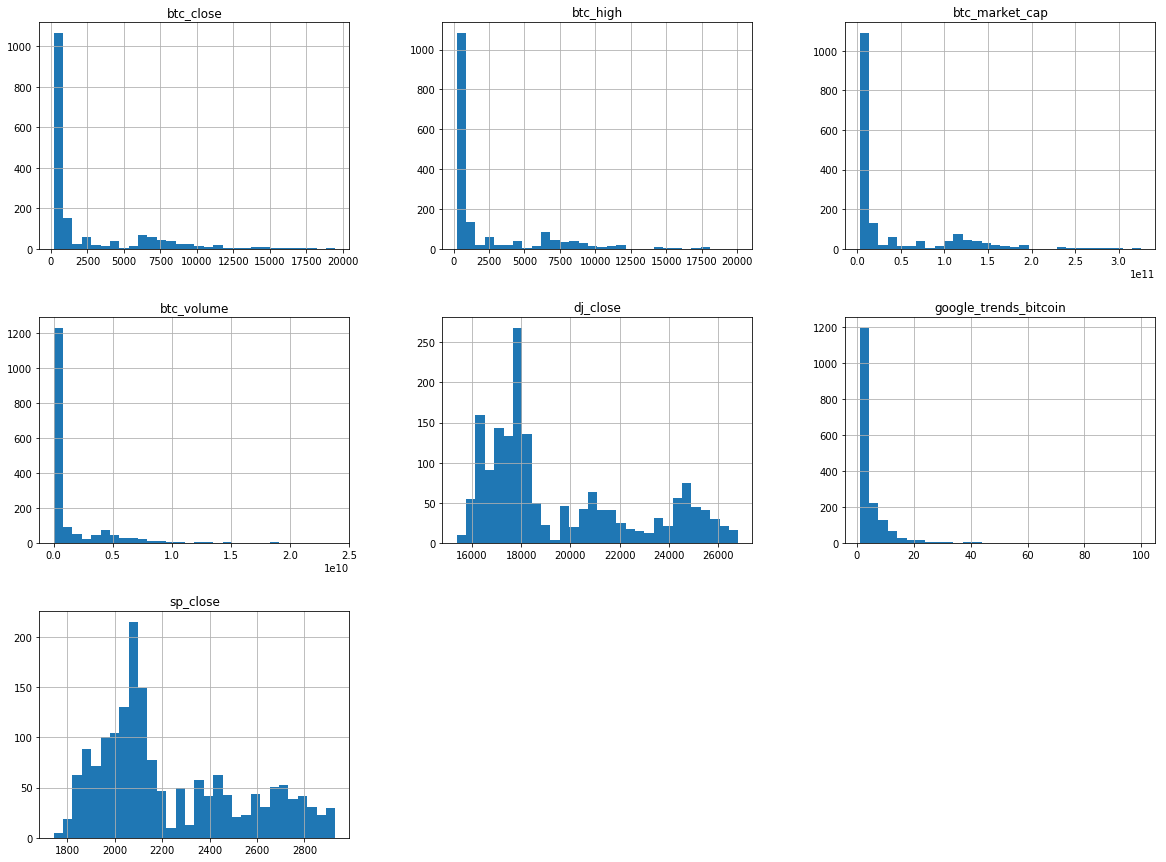

In [15]:
model_data.hist(bins=30, figsize=(20,15))
# print(all_coins_df)
plt.show()

#### Normalizimi te dhenave duke perdorur metoden Min-Max scaling

In [23]:
# Perdor scikit-learn per normalizim
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer, StandardScaler

model_data.fillna(model_data.mean(),inplace=True)

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

model_data_without_date = model_data.loc[:, model_data.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(model_data_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(model_data_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = model_data_without_date.columns)

imputed_df[['btc_high', 'btc_close', 'btc_volume', 'btc_market_cap', \
       'bch_avg_block_size', 'bch_transactions', 'bch_mining_revenue', \
       'bch_accounts', 'sp_close', 'dj_close', 'google_trends_bitcoin']] = \
        minmax_scale(imputed_df[['btc_high', 'btc_close', 'btc_volume', \
                                 'btc_market_cap', 'bch_avg_block_size', \
                                 'bch_transactions', 'bch_mining_revenue', 'bch_accounts', 'sp_close', 'dj_close', 'google_trends_bitcoin']])
# Re add date column
imputed_df['date'] = model_data['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::1]

model_data=imputed_df

#### Rirenditja e kolonave duke vendosur 'daten' si kolonen e pare

In [24]:
model_data=model_data[['date','btc_high', 'btc_close', 'btc_volume', 'btc_market_cap', \
       'bch_avg_block_size', 'bch_transactions', 'bch_mining_revenue', \
       'bch_accounts', 'sp_close', 'dj_close', 'google_trends_bitcoin']]

#### Ruajtja e model_data per t'u perdorur gjate trajnimit/testimit

In [25]:
model_data.to_csv('model_data.csv')

In [26]:
a = pd.read_csv('model_data.csv').iloc[:, 1:]
a = a.assign(date=pd.to_datetime(a['date']))
a = a.sort_values(by='date')
a

,date,btc_high,btc_close,btc_volume,btc_market_cap,bch_avg_block_size,bch_transactions,bch_mining_revenue,bch_accounts,sp_close,dj_close,google_trends_bitcoin
0,2018-10-04,0.321552,0.331202,0.160900,0.339832,0.727437,0.523625,0.214075,1.000000,0.975489,0.982462,0.041894
1,2018-10-03,0.319950,0.327366,0.162952,0.342786,0.727437,0.523625,0.205355,0.999343,0.995592,1.000000,0.043462
2,2018-10-02,0.321981,0.330136,0.166809,0.344857,0.746110,0.524973,0.238706,0.998520,0.993843,0.995247,0.041894
3,2018-10-01,0.324067,0.331871,0.167720,0.346238,0.746110,0.524973,0.245823,0.997272,0.994819,0.984533,0.038760
4,2018-09-30,0.323588,0.333732,0.167775,0.345387,0.584187,0.461143,0.227486,0.996607,0.985894,0.967694,0.037192
5,2018-09-29,0.323554,0.332510,0.182936,0.347399,0.584187,0.461143,0.236537,0.995442,0.985894,0.967694,0.037192
6,2018-09-28,0.330694,0.334693,0.210234,0.349265,0.765816,0.540268,0.213521,0.994664,0.985894,0.967694,0.046597
7,2018-09-27,0.327025,0.336381,0.193135,0.339428,0.765816,0.540268,0.204635,0.993679,0.985911,0.966090,0.045029
8,2018-09-26,0.320677,0.326974,0.186024,0.337123,0.658221,0.549203,0.248511,0.992493,0.979156,0.961319,0.046597
9,2018-09-25,0.321569,0.324462,0.198142,0.345137,0.658221,0.549203,0.223961,0.991402,0.987223,0.970654,0.048164


#### Leximi i te dhenave

In [19]:
# model_data = model_data.sort_values(by='date')
model_data.head()
# First Order Differencing
# exchange_data['btc_close'].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
# """
#     Removing the trends seems almost atrocious; The bubbles are very apparent
# """
# plt.xlabel('Year', fontsize=20);

,date,btc_high,btc_close,btc_volume,btc_market_cap,bch_avg_block_size,bch_transactions,bch_mining_revenue,bch_accounts,sp_close,dj_close,google_trends_bitcoin
0,2014-01-01,0.321552,0.331202,0.160900,0.339832,0.727437,0.523625,0.214075,1.000000,0.975489,0.982462,0.041894
1,2014-01-02,0.319950,0.327366,0.162952,0.342786,0.727437,0.523625,0.205355,0.999343,0.995592,1.000000,0.043462
2,2014-01-03,0.321981,0.330136,0.166809,0.344857,0.746110,0.524973,0.238706,0.998520,0.993843,0.995247,0.041894
3,2014-01-04,0.324067,0.331871,0.167720,0.346238,0.746110,0.524973,0.245823,0.997272,0.994819,0.984533,0.038760
4,2014-01-05,0.323588,0.333732,0.167775,0.345387,0.584187,0.461143,0.227486,0.996607,0.985894,0.967694,0.037192


In [175]:
# bitcoin_market_info = pd.read_csv("bitcoin_market_info.csv").iloc[:, 1:]
# txs_data = pd.read_csv("txs_data.csv").iloc[:, 1:]
# avg_block_size_data = pd.read_csv("avg_block_size_data.csv").iloc[:, 1:]
# btc_google_trends = pd.read_csv("btc_google_trends.csv").iloc[:, 1:]
# bch_accounts_data = pd.read_csv("bch_accounts_data.csv").iloc[:, 1:]
# s_and_p_stock_data = pd.read_csv('s_and_p_stock.csv').iloc[:, 1:]
# dow_jones_stock_data = pd.read_csv('dow_jones_stock.csv').iloc[:, 1:]
# bchain_mirev_data = pd.read_csv('bchain_mirev_data.csv').iloc[:, 1:]